# Принятие решений в бизнесе

Описание:  Имеются гипотезы для увеличения выручки интернет-магазина, подготовленные совместно с отделом маркетинга.  
Цель:  
При помощи A/B-тест и проанализировать результаты предложенных гипотиз по  увеличению выручки.

Задачи:  
Проанализировать данные,  
Приоритизировать гипотезы,  
Анализ А/В теста.  

Данные:

Таблица hypothesis 

Hypothesis — краткое описание гипотезы;  
Reach — охват пользователей по 10-балльной шкале;  
Impact — влияние на пользователей по 10-балльной шкале;  
Confidence — уверенность в гипотезе по 10-балльной шкале;  
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  
 
Таблица orders

transactionId — идентификатор заказа;  
visitorId — идентификатор пользователя, совершившего заказ;  
date — дата, когда был совершён заказ;  
revenue — выручка заказа;  
group — группа A/B-теста, в которую попал заказ.  

Таблица visitors  

date — дата;  
group — группа A/B-теста;  
visitors — количество пользователей в указанную дату в указанной группе A/B-теста  

 


## Просмотр и подготовка данных.

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import math
from scipy import stats

from datetime import timedelta
import datetime as dt

from statsmodels.stats.proportion import proportions_ztest
import warnings



In [3]:
# загрузка данных 
df_hypothesis = pd.read_csv('/datasets/hypothesis.csv') 

In [4]:
df_hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [5]:
df_orders = pd.read_csv('/datasets/orders.csv')

In [6]:
df_orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
df_visitors = pd.read_csv('/datasets/visitors.csv')

In [9]:
df_visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [10]:
df_visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [11]:
round((df_visitors.isna().mean()*100),2)

date        0.0
group       0.0
visitors    0.0
dtype: float64

In [12]:
round((df_orders.isna().mean()*100),2)

transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64

In [13]:
df_orders.duplicated().sum()

0

In [14]:
df_visitors.duplicated().sum()

0

При первично просмотре определено, что необходимо:  
- изменить заголовки в таблице - df_hypothesis,  
- изменить тип данных. 


## Предработка данных.

In [15]:
#заголовки - все строчные
df_hypothesis.columns = df_hypothesis.columns.str.lower() 

In [16]:
df_orders['date'] = df_orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [17]:
df_visitors['date'] = df_visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [18]:
df_visitors.info()
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


##  Приоритизация гипотез.

Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [19]:
df_hypothesis['ICE'] = ((df_hypothesis['impact'] * df_hypothesis['confidence']) / df_hypothesis['efforts']).round(2)


In [20]:
pd.options.display.max_colwidth = 150
df_hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективные гипотезы по ICE - это  "Запустить акцию, дающую скидку на товар в день рождения", "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [21]:
df_hypothesis['RICE'] = ((df_hypothesis['reach']*df_hypothesis['impact']*df_hypothesis['confidence']) / df_hypothesis['efforts']).round(2)

df_hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [22]:
df_hypothesis[['hypothesis', 'ICE', 'RICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0


Наиболее перспективные гипотезы по RICE - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа", "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей". 

При пеменении RICE вместо ICE мы видим несоответствие по приоритизация гипотез. Те гипотезы, которые мы считали наиболее перспективными по ICE, далеко не самые перспективные по RICE. Но все же гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", находится в тройке лучших по RICE (на первом месте) по ICE (на третьем месте). На мой взгляд так произошло потому, что при расчете RICE учитывается показатель reach (охват пользователей), который в значистельной степени вляет на результат.

Изучен файл с 9 гипотезами по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Применен фреймворк ICE для приоритизации гипотез. Наиболее перспективные гипотезы по ICE - это гипотезы "Запустить акцию, дающую скидку на товар в день рождения", "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

Применен фреймворк RICE для приоритизации гипотез. Наиболее перспективные гипотезы по RICE - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа", "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".

Гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", находится в тройке лучших по RICE (на первом месте) по ICE (на третьем месте)

##  Анализ A/B-теста.

In [23]:
df_orders['visitorId'].value_counts() #смотрим по количеству заказов 

#transactionId — идентификатор заказа;
#visitorId — идентификатор пользователя, совершившего заказ;

4256040402    11
2458001652    11
2378935119     9
2038680547     8
199603092      5
              ..
2406916810     1
1255412427     1
3866069709     1
54447517       1
3013339133     1
Name: visitorId, Length: 1031, dtype: int64

In [24]:
df_orders['visitorId'].count()

1197

In [25]:
df_orders['transactionId'].count()

1197

В представленных данных с заказами фигурирует 1031 уникальных пользователя. Самое большое число заказов по покупателю - 11. Всего записей также 1197.

In [26]:
df_orders['date'].value_counts()

2019-08-05    48
2019-08-12    47
2019-08-14    47
2019-08-15    46
2019-08-06    46
2019-08-01    45
2019-08-28    45
2019-08-02    44
2019-08-27    44
2019-08-08    43
2019-08-19    43
2019-08-29    42
2019-08-07    42
2019-08-26    41
2019-08-22    41
2019-08-09    41
2019-08-03    40
2019-08-23    40
2019-08-10    39
2019-08-16    38
2019-08-21    37
2019-08-30    35
2019-08-13    35
2019-08-04    33
2019-08-20    32
2019-08-31    32
2019-08-24    31
2019-08-18    26
2019-08-11    26
2019-08-17    24
2019-08-25    24
Name: date, dtype: int64

In [96]:
df_orders['date'].describe()


/tmp/ipykernel_24/2857408867.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_orders['date'].describe()


count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

Представлены заказы за август 2019 года. 1197 строк всего, из них уникальных - 31. В дату 2019-08-05 было совершено самое большое число заказов - 48.

In [28]:
df_orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

В колонке с группами у нас неравное число участников: в  А - 557 человек, в  B - 640.

In [29]:
double = df_orders.pivot_table(index='visitorId', values='group', aggfunc='nunique')
double.reset_index()
double.query('group > 1').count()

group    58
dtype: int64

58 пользователей попадает в обе группы. Это 5% от общего числа. На мой взгляд удаление не скажется на результатах тестов. Оставляю. 

### График кумулятивной выручки по группам. 

In [30]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = df_orders[['date','group']].drop_duplicates() 

In [31]:
datesGroups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [32]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: df_orders[
        np.logical_and(
            df_orders['date'] <= x['date'], df_orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': pd.Series.nunique,
            'visitorId': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

In [33]:
ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [34]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: df_visitors[np.logical_and(df_visitors['date'] <= x['date'], df_visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])


In [35]:
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [36]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [37]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [38]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueA.head()

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


In [39]:
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
cumulativeRevenueB.head()

,date,revenue,orders
1,2019-08-01,101217,21
3,2019-08-02,266748,45
5,2019-08-03,380996,61
7,2019-08-04,489567,78
9,2019-08-05,581995,101


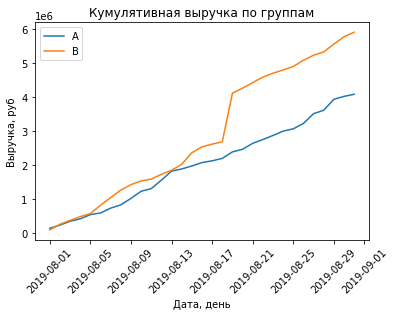

In [40]:
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=45)
plt.legend() 
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата, день')
plt.ylabel('Выручка, руб')


plt.show()

Выручка почти равномерно увеличивается в течение всего теста. В начале сегмент B пошел вверх и лидировал, далее, в середине августе, видим довольно резкий скачок сегмента B. Это возможно увеличение числа заказов, либо о появлении очень дорогих заказов в выборке.

###  График кумулятивного среднего чека по группам.

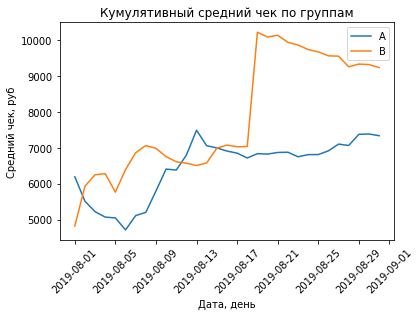

In [41]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата, день')
plt.ylabel('Средний чек, руб')
plt.legend() 

Кумулятивное значение среднего чека нестабильно. После 17 августа со средним чеком сегмента В что-то случилось, и он резко увеличился(стал свыше 10000). Пик для семента А пришелся на 13 августа (7000-8000), после чего немного снизился.

### График относительного изменения кумулятивного среднего чека группы B к группе A. 

In [42]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

Text(0, 0.5, 'Отношение средних чеков')

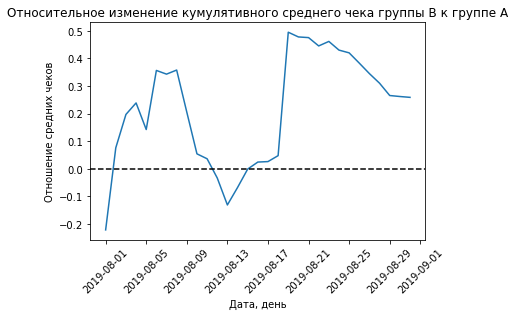

In [43]:
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation=45)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата, день')
plt.ylabel('Отношение средних чеков')

Результаты теста значительно и резко менялись в несколько дат. Вероятно, в эти дни были соверешены большие заказы.

### График кумулятивной конверсии по группам.

In [44]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


In [45]:
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
 
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

Text(0, 0.5, 'Конверсия')

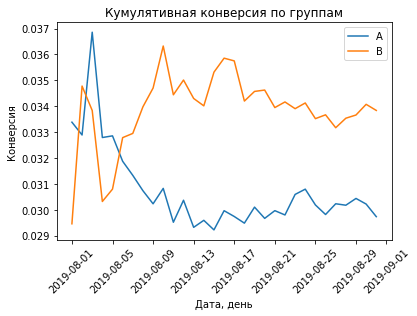

In [46]:
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.title("Кумулятивная конверсия по группам")
plt.xlabel('Дата, день')
plt.ylabel('Конверсия')

В начале теста по графикам мы видим, что сегмент А имел большую конверсию, чем сегмент В, но далее мы видим резкую смену позиций. Пересечение сегментов на уровне 0.032, а делее увеличение по сегменту В, до максимума - 0.036 и снижение сегмента А до 0.029.

### График относительного изменения кумулятивной конверсии группы B к группе A. 

In [47]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

mergedCumulativeConversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


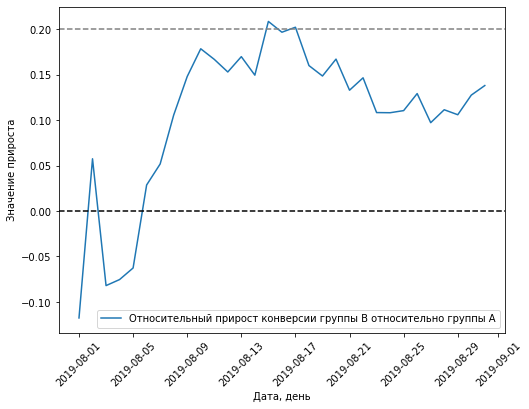

In [48]:
plt.figure(figsize=(8,6))
plt.plot(
    mergedCumulativeConversions['date'], 
    mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
    label="Относительный прирост конверсии группы B относительно группы A"
)
plt.legend()
plt.xlabel('Дата, день')
plt.ylabel('Значение прироста')

plt.xticks(rotation=45)

# линия оси X чёрного цвета  
plt.axhline(y=0, color='black', linestyle='--')
# линия оси X серого цвета  
plt.axhline(y=0.2, color='grey', linestyle='--')
 
plt.show()
 


В начале теста группа B проигрывала группе A, затем видим резкий подъем. В период с 7 по 15 августа набладается прирост до уровня 0.22, а после чего стала немного падать до уровня 0.1, но все равно остается в выигрышной позиции по по сравнению с группой А. В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя.

### Точечный график количества заказов по пользователям.

In [49]:
df_orders.head()
#transactionId — идентификатор заказа;
#visitorId — идентификатор пользователя, совершившего заказ;

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [50]:
#число заказов по пользователям
ordersByUsers = (
    df_orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


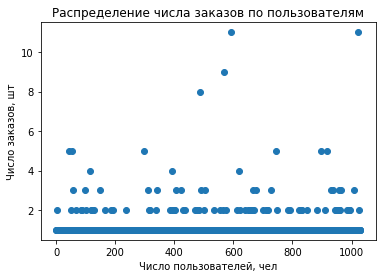

In [51]:
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 

plt.title('Распределение числа заказов по пользователям')
plt.xlabel('Число пользователей, чел')
plt.ylabel('Число заказов, шт')
plt.show()

Видим, что максимальное количество заказов достигает - 11 от двух пользователей. Случаи заказов более двух раз не так уж и много. Больше всего по одному - два заказа.

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [52]:
# Метод np.percentile('column', [percentile1, percentile2, percentile3]) находит перцентили.
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей совершали больше двух заказов. И не более 1% пользователей - больше четырех заказов.

### Точечный график стоимостей заказов. 

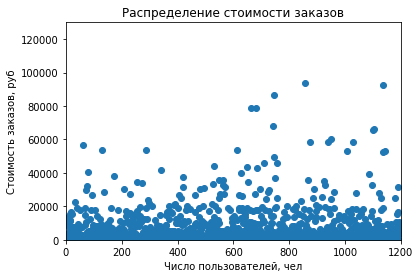

In [53]:
x_values = pd.Series(range(0, len(df_orders['revenue'])))

plt.scatter(x_values, df_orders['revenue']) 

plt.title('Распределение стоимости заказов')
plt.xlabel('Число пользователей, чел')
plt.ylabel('Стоимость заказов, руб')
plt.axis([0, 1200, 0, 130000])

plt.show()

Видим, что есть заказы аномально дорогостоящие - около 100 000. В целом к аномальным можно отнести заказы выше 40 000.

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [54]:
print(np.percentile(df_orders['revenue'], [95, 99]))

[28000.  58233.2]


In [55]:
df_orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


(100.0, 59000.0)

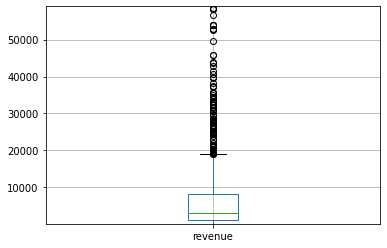

In [56]:
df_orders.boxplot(column='revenue')
plt.ylim(100, 59000)

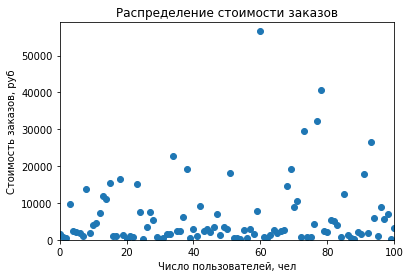

In [57]:
x_values = pd.Series(range(0, len(df_orders['revenue'])))

plt.scatter(x_values, df_orders['revenue']) 

plt.title('Распределение стоимости заказов')
plt.xlabel('Число пользователей, чел')
plt.ylabel('Стоимость заказов, руб')
plt.axis([0, 100, 0, 59000])

plt.show()

Не более, чем у 5% заказов чек дороже 28000. И не больше, чем у 1% заказов чек дороже 58233 т.р.

### Статистическая значимость различий в конверсии между группами по «сырым» данным.  

In [58]:
df_orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [59]:
# по дням данные о посетителях группы А
visitorsADaily = df_visitors[df_visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsADaily.head()

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [60]:
# кумулятивные данные о посетителях группы А
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsACummulative.head()

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [61]:
#  по дням данные о посетителях группы В
visitorsBDaily = df_visitors[df_visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [62]:
# кумулятивные данные о посетителях группы В
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
visitorsBCummulative.head()

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [63]:
# агрегированные данные по дням о заказах и выручке группы А 
ordersADaily = (
    df_orders[df_orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
ordersADaily.head()

#transactionId — идентификатор заказа;
#visitorId — идентификатор пользователя, совершившего заказ;

,date,ordersPerDateA,revenuePerDateA
0,2019-08-01,24,148579
1,2019-08-02,20,93822
2,2019-08-03,24,112473
3,2019-08-04,16,70825
4,2019-08-05,25,124218


In [64]:
# кумулятивные данные по дням о заказах и выручке группы А 
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersACummulative.head()

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917


In [65]:
# агрегированные данные по дням о заказах и выручке группы В
ordersBDaily = (
    df_orders[df_orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
ordersBDaily.head()

,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,21,101217
1,2019-08-02,24,165531
2,2019-08-03,16,114248
3,2019-08-04,17,108571
4,2019-08-05,23,92428


In [66]:
# кумулятивные данные по дням о заказах и выручке группы В
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]
ordersBCummulative.head()

,date,ordersCummulativeB,revenueCummulativeB
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996
3,2019-08-04,78,489567
4,2019-08-05,101,581995


In [67]:

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)


In [68]:
# данные по одному заказу в группе А
ordersByUsersA = (
    df_orders[df_orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']
ordersByUsersA.head()

,visitorId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [69]:
# данные по одному заказу в группе В
ordersByUsersB = (
    df_orders[df_orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']
ordersByUsersB.head()

,visitorId,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


In [70]:
#sampleA выборка, где каждый элемент — число заказов определённого пользователя, в том числе ноль. 

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
sampleA.count()

18736

In [71]:
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
sampleB.count()

18916

Гипотезы:

Н0 - Статистически значимых различий в конверсии между группами по сырым данным нет.

Н1 - Статистически значимых различий в конверсии между группами по сырым данным есть.

In [72]:
p_val_conversion = (stats.mannwhitneyu(sampleA, sampleB,alternative = 'two-sided')[1]).round(5)

print("P-value по конверсии до очистки данных: {0:.3f}".format(p_val_conversion))


P-value по конверсии до очистки данных: 0.017


In [73]:
relative_increase_conversion = sampleB.mean() / sampleA.mean() - 1
print("Относительный прирост конверсии группы B: {0:.3f}".format(relative_increase_conversion))

Относительный прирост конверсии группы B: 0.138


In [74]:
alpha = .05

if (p_val_conversion < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


P-value значительно меньше 0.05 (критического значение для теста, т.е. максимально допускается, что не более чем 5%-ая вероятность ошибки) поэтому нулевую гипотезу отвергаем. Анализ "сырых" данных показывает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы B составляет около 13%

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.  

Гипотезы: 

Н0 - Статистически значимых различий в в среднем чеке заказа между группами по сырым данным нет.

Н1 - Статистически значимых различий в в среднем чеке заказа между группами по сырым данным есть.

In [75]:
revenue_A = df_orders[df_orders['group']=='A']['revenue']

In [76]:

revenue_B = df_orders[df_orders['group']=='B']['revenue']

In [77]:
p_val_avg_check = (stats.mannwhitneyu(revenue_A, revenue_B,alternative = 'two-sided')[1]).round(3)

print('P-value по среднему чеку до очистки данных: {}'.format(p_val_avg_check))

P-value по среднему чеку до очистки данных: 0.729


In [78]:

relative_increase_avg_check = revenue_B.mean() / revenue_A.mean() - 1

print('Относительный прирост среднего чека группы B к среднему чеку группы А до очистки данных: {:.2f}'.format(relative_increase_avg_check))

Относительный прирост среднего чека группы B к среднему чеку группы А до очистки данных: 0.26


In [79]:
alpha = .05

if (p_val_avg_check < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


P-value больше 0.05 - статистически значимых различий в среднем чеке заказа между группами по «сырым» данным нет. 

### Статистическая значимость различий в конверсии между группами по «очищенным» данным.  

Было определено, что 95-й и 99-й перцентили средних чеков равны 28000 и 58233.2 рублям.
95-й и 99-й перцентили числа заказов на одного пользователя равны 2 и 4 заказам на пользователя.
Из этого обозначим, что аномалиями будут те пользователи, которые совершили 4 заказа и более, или совершил заказ на сумму свыше 30 000 рублей.

In [81]:
#переменная со значением перцентиля
df_orders_orders_percentile = int(np.percentile(ordersByUsers['orders'], [98]))

In [82]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > df_orders_orders_percentile]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > df_orders_orders_percentile]['visitorId'],
    ],
    axis=0,
)

In [83]:
print(np.percentile(df_orders['revenue'], [95]))

[28000.]


In [84]:
#переменная со значением перцентиля
df_orders_revenue_percentile = int(np.percentile(df_orders['revenue'], [95]))

In [85]:
usersWithExpensiveOrders = df_orders[df_orders['revenue'] > df_orders_revenue_percentile]['visitorId']

#transactionId — идентификатор заказа;
#visitorId — идентификатор пользователя, совершившего заказ;

In [86]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head()

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
Name: visitorId, dtype: int64

Гипотезы

Н0 - Статистически значимых различий в конверси между группами с «очищенными» данным нет.

Н1 - Статистически значимых различий в конверси между группами с «очищенными» данным есть.

In [87]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [88]:
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [89]:
p_val_conversion_clean = (stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]).round(5)

print('P-value по конверсии после очистки данных: {}'.format(p_val_conversion_clean))

P-value по конверсии после очистки данных: 0.01794


In [90]:
 relative_increase_conversion_clean = sampleBFiltered.mean()/sampleAFiltered.mean()-1

print('Относительный прирост конверсии группы B к конверсии группы А после очистки данных: {:.2f}'.format(relative_increase_conversion_clean))

Относительный прирост конверсии группы B к конверсии группы А после очистки данных: 0.15


In [91]:
alpha = .05

if (p_val_conversion_clean < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


Как и в случае с сырыми данными, статистическая значимость достигнута. Отвергаем нулевую гипотезу. Сегмент B лучше сегмента А. 

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

Гипотезы:

Н0 - Статистически значимых различий в в среднем чеке заказа между группами по очищенным данным нет.

Н1 - Статистически значимых различий в в среднем чеке заказа между группами по очищенным данным есть.

In [92]:
#фильтр аномальных пользователей
sampleAFiltered_revenue = df_orders[
                np.logical_and(
                    df_orders['group'] == 'A',
                    np.logical_not(df_orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue']

sampleBFiltered_revenue = df_orders[
                np.logical_and(
                    df_orders['group'] == 'B',
                    np.logical_not(df_orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue']

In [93]:
p_val_avg_check_clean = (stats.mannwhitneyu(
    sampleAFiltered_revenue, 
    sampleBFiltered_revenue, 
    alternative = 'two-sided')[1]).round(5)

print('P-value по среднему чеку по отчищенным данным: {:.3f}'.format(p_val_avg_check_clean))

P-value по среднему чеку по отчищенным данным: 0.977


In [94]:
relative_increase_avg_check_clean = sampleBFiltered_revenue.mean()/sampleAFiltered_revenue.mean()-1

print('Прирост среднего чека группы B к среднему чеку группы А по отчищенным данным: {:.2f}'.format(relative_increase_avg_check_clean))

Прирост среднего чека группы B к среднему чеку группы А по отчищенным данным: -0.02


In [95]:
alpha = .05

if (p_val_avg_check_clean < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


Статистической значимости различия между средними чеками не появилось. P-value увеличился до 0.958

### Принятие решения по результатам теста.

Опираясь на полученные результаты тестов, пришла к выводу, что стоит зафиксировать победу группы В. Группа B статистически значимо лучше группы A по метрике конверсии, но различий в средних чеках нет. Цель проекта стоит в эффективности гипотезы по увеличению выручки, т.к. коверсия влияет на выручку, а конверсия в случае группы В значимо увеличилась, то и выручка увеличилась тоже. Даже с учетом того, что средний чек остался без изменений. 


##  Вывод  

В процессе работы над проектом были изучены предстваленные гипотезы и выполнена их  приоритизация с помощью ICE и RICE. Где было определено, что по ICE приоритетная гипотиза - "Запустить акцию, дающую скидку на товар в день рождения", а  по RICE - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". В топ обоих методов вошла гипотеза  "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", находится в тройке лучших по RICE (на первом месте) по ICE (на третьем месте)



Далее были изучены заказы за август 2019 года. где максимальное число заказов на покумателя составило - 11, а максимальная сумма заказа составила около 100 000 руб. 
- Кумулятивная выручка почти равномерно увеличивается в течение всего теста. С самого начала и на протяжении теста  сегмент B лидировал. В середине августа видим довольно резкий скачок сегмента B. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 
- Кумулятивное значение среднего чека довольно нестабильно. Видно, что с середины августа со средним чеком сегмента В что-то произошло, и он резко увеличился (стал свыше 10000). Пик для семента А пришелся на 13 августа (7000-8000), после чего немного снизился до 6500.
- Кумулятивная конверсия по дням по группам показала, что в начале сегмент А имел большую конверсию, но после чуть упал и выровнялся до уровня 0.03. Сегмент B наоборот начал с 0.03 и стабилизировася на значении 0.035.
- Различие кумулятивной конверсии группы B к группе A показало, что в начале теста группа B проигрывала группе A, затем видим резкий подъем. В период с 7 по 15 августа набладается прирост до уровня 0.22, а после чего стала немного падать до уровня 0.1, но все равно остается в выигрышной позиции по по сравнению с группой А. 

В последующем, были изучены статистическая значимость различий в среднем чеке и конверсии по "сырым" и очищенным данным.

-  в конверсии между группами по "сырым" данным есть статистически значимые различия. Относительный прирост конверсии группы B к конверсии группы А равен 13%.
-  статистически значимых различий в среднем чеке заказа между группами по «сырым» данным нет. Относительное различие среднего чека между группами всего 2.6%.

После отчистки от аномалий, а к аномалиям я отнесла дорогие заказы (свыше 30 тыс. ) и  большое количество заказов (более 4). 

- статистическая значимость в конверсии между группами достигнута. Сегмент B лучше сегмента А. Относительный прирост конверсии группы B к А стал равен 15%.
- статистической значимости различия между средними чеками не появилось. P-value увеличился до 0.958, а разница между сегментами стала -0.02.

По результатам теста было принято решение остановить проверку и признать победу группы В. Группа B статистически значимо лучше группы A по метрике конверсии, но различий в средних чеках нет. Цель проекта стоит в эффективности гипотезы по увеличению выручки, т.к. коверсия влияет на выручку, а  конверсия в случае группы В значимо увеличилась, то и выручка увеличилась тоже. Даже с учетом того, что средний чек остался без изменений.

